In [1]:

import re
import os
import sys
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import networkx as nx
import pybedtools as bt
from scipy import stats

from scipy.spatial import distance
from scipy.cluster import hierarchy

from scipy.stats import spearmanr, norm
from adjustText import adjust_text



import matplotlib.patches as mpatches
import matplotlib.collections as mcol

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from matplotlib.lines import Line2D
from mycolorpy import colorlist as mcp

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib_venn import venn2

color1=mcp.gen_color(cmap="Reds",n=10)[-7:-2]
color2=mcp.gen_color(cmap="Greys",n=10)[-5:]
color3=mcp.gen_color(cmap="Oranges",n=10)[-7:-2]
color4=mcp.gen_color(cmap="Greens",n=10)[-7:-2]
color5=mcp.gen_color(cmap="Purples",n=10)[-7:-2]
sns.set(style="ticks", font_scale=2)

mcp.gen_color(cmap="Purples",n=10)[-7:-2]

H = pickle.load( open('../January-23/data/G_ALL.p', 'rb'))
MAPty = pickle.load(open('../January-23/data/MAPty.p', 'rb'))
MAPgn = pickle.load(open('../January-23/data/MAPgn.p', 'rb'))
MAPcl = pickle.load(open('../January-23/data/MAPcl.p', 'rb'))

BEDPRO = pd.read_table('../June-23/BEDPRO_new.tsv')
N = pd.read_table('../data/TABLE/Epigenome.tmm.tsv').set_index('Name').drop_duplicates()
print(BEDPRO.shape, N.shape)

sns.set(style="ticks", font_scale=2)

def flatten(l):
    return [item for sublist in l for item in sublist]


(13452, 19) (78245, 30)


In [2]:


nodes = [k for k, v in MAPty.items() if v == 'Promoter']
nodes = [k for k, v in MAPcl.items() if v == 'ANDR']

nodes = BEDPRO.loc[(BEDPRO['Quartile'] == "ANDR") & (BEDPRO['Expression'] > 50) & ((((BEDPRO['4h'] + BEDPRO['16h'])/2) / BEDPRO['Vh']) > 1.5), 'Name']
nodes = BEDPRO.loc[BEDPRO['Gene'].isin(['KLK2', 'KLK3', 'NKX3-1', 'UAP1', 'ABCC4', 'DHCR24']), 'Name'].tolist()

GI_P = []
is_min_ac = []
is_min_me = []

B = []
D = []
for p in nodes:

    if p not in H:
        continue
    
    neig = list(H.neighbors(p))
    ns = Counter([MAPcl[n] for n in neig])

    #print(p in neig)

    ds = []
    p_c = sum([int(i) for i in p.split(':')[1].split('-')]) / 2
    for n in neig:
        n_c = sum([int(i) for i in n.split(':')[1].split('-')]) / 2
        ds.append(np.abs(p_c - n_c))

    neig_ac = [n for n in neig if MAPcl[n] == 'ARcre']
    neig_ac = neig

    if (len(neig) < 5) or (len(neig_ac) == 0):
        continue 
    
    T_ac = {'Vh':[], '30m':[], '4h':[], '16h':[], '72h':[]}
    Tac = np.zeros((len(neig_ac), 5))
    for i, e in enumerate(neig_ac): 
        w = H.get_edge_data(p, e)
        for j, t in enumerate(['Vh', '30m', '4h', '16h', '72h']):
            T_ac[t].append(w[f'H3K27ac.{t}'])
            Tac[i,j] = w[f'H3K27ac.{t}']
    
    T_me = {'Vh':[], '30m':[], '4h':[], '16h':[], '72h':[]}
    Tme = np.zeros((len(neig_ac), 5))
    for i, e in enumerate(neig_ac): 
        w = H.get_edge_data(p, e)
        for j, t in enumerate(['Vh', '30m', '4h', '16h', '72h']):
            T_me[t].append(w[f'H3K4me3.{t}'])
            Tme[i,j] = w[f'H3K4me3.{t}']

    #print(Tac.std(1).argmax(), Tme.std(1).argmax()) 
    #if Tac.std(1).argmax() == Tme.std(1).argmax():
    is_min_ac.append(np.argmin(ds) == Tac.std(1).argmax())
    is_min_me.append(np.argmin(ds) == Tme.std(1).argmax())

    for i, e in enumerate(neig_ac): 

        B.append((MAPgn[p], p, neig_ac[Tac.std(1).argmax()], neig_ac[Tme.std(1).argmax()], 
                  MAPcl[e], e, 
                  Tac.std(1)[i], Tme.std(1)[i],
                  np.log2((Tac[i, 3]+1) / (Tac[i, 0]+1)),
                  np.log2((Tme[i, 3]+1) / (Tme[i, 0]+1))     
                  ))


    D.append([MAPgn[p],p, ns['ARcre'], ns['cre'] ,int(np.min(ds)),  neig_ac[Tac.std(1).argmax()],int(ds[Tac.std(1).argmax()]), neig_ac[Tme.std(1).argmax()], int(ds[Tme.std(1).argmax()])])
        
	
Counter(is_min_ac), Counter(is_min_me)

D = pd.DataFrame(D, columns=['Gene', 'Promoter', 'nARloop', 'nCREloop','ClosestInteraction','Dominant_ac', 'DominantDistance_ac', 'Dominant_me', 'DominantDistance_me'])


D['Pairs_AC'] = D['Promoter'] + ';' + D['Dominant_ac']
D['Pairs_me'] = D['Promoter'] + ';' + D['Dominant_me']

D

,Gene,Promoter,nARloop,nCREloop,ClosestInteraction,Dominant_ac,DominantDistance_ac,Dominant_me,DominantDistance_me,Pairs_AC,Pairs_me
0,UAP1,chr1:162528823-162533823,4,15,7486,chr1:162536309-162541309,7486,chr1:162536309-162541309,7486,chr1:162528823-162533823;chr1:162536309-162541309,chr1:162528823-162533823;chr1:162536309-162541309
1,DHCR24,chr1:55350391-55355391,2,19,4533,chr1:55345858-55350858,4533,chr1:55345858-55350858,4533,chr1:55350391-55355391;chr1:55345858-55350858,chr1:55350391-55355391;chr1:55345858-55350858
2,ABCC4,chr13:95951183-95956183,3,9,13293,chr13:95917889-95922889,33294,chr13:95964476-95969476,13293,chr13:95951183-95956183;chr13:95917889-95922889,chr13:95951183-95956183;chr13:95964476-95969476
3,KLK3,chr19:51355671-51360671,4,3,3655,chr19:51352016-51357016,3655,chr19:51362463-51367463,6792,chr19:51355671-51360671;chr19:51352016-51357016,chr19:51355671-51360671;chr19:51362463-51367463
4,KLK2,chr19:51374195-51379195,2,2,4119,chr19:51370076-51375076,4119,chr19:51370076-51375076,4119,chr19:51374195-51379195;chr19:51370076-51375076,chr19:51374195-51379195;chr19:51370076-51375076
5,NKX3-1,chr8:23537940-23542940,8,10,11,chr8:23535963-23540963,1977,chr8:23535963-23540963,1977,chr8:23537940-23542940;chr8:23535963-23540963,chr8:23537940-23542940;chr8:23535963-23540963


In [3]:

import sys
sys.path.append("/home/ualtintas/bluegill/")
import bluegill.run as bgrun
import bluegill.plt as bgplt

In [4]:
BED = pd.read_table('../January-23/data/CRE.bed', names=['Chr', 'Start', 'End', 'Name'])

BWS = [
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/ATAC_Vh.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/ATAC_30m.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/ATAC_4h.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/ATAC_16h.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/ATAC_72h.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/AR_Vh.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/AR_30m.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/AR_4h.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/AR_16h.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/AR_72h.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/FOXA1_Vh.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/FOXA1_30m.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/FOXA1_4h.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/FOXA1_16h.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/FOXA1_72h.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/H3K27ac_Vh.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/H3K27ac_30m.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/H3K27ac_4h.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/H3K27ac_16h.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/H3K27ac_72h.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/H3K4me3_Vh.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/H3K4me3_30m.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/H3K4me3_4h.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/H3K4me3_16h.bw",
	"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/H3K4me3_72h.bw",
	'/groups/lackgrp/projects/inv-wholegenomeSTARRseq/WGSTARR/results/tracks/LNCaP.WG.EtOH.avg_RPKM.bw',
	'/groups/lackgrp/projects/inv-wholegenomeSTARRseq/WGSTARR/results/tracks/LNCaP.WG.DHT.avg_RPKM.bw'
]

Nbins=1
h=0

BED, samples = bgrun.runSignal(BED, BWS, "CORR.p",  Nbins=Nbins, h=h, nP=50, igv=True)
#BED.to_csv('NEW-hg38.bed', index=False, sep='\t')




0: ATAC_Vh.bw :: 1: ATAC_Vh.bw :: 2: ATAC_Vh.bw :: 3: ATAC_Vh.bw :: 4: ATAC_Vh.bw :: 5: ATAC_Vh.bw :: 6: ATAC_Vh.bw ::  :: 7: ATAC_Vh.bw8: ATAC_Vh.bw :: 9: ATAC_Vh.bw :: 10: ATAC_Vh.bw ::  :: 11: ATAC_Vh.bw12: ATAC_Vh.bw :: 13: ATAC_Vh.bw :: 14: ATAC_Vh.bw :: 15: ATAC_Vh.bw :: 16: ATAC_Vh.bw :: 17: ATAC_Vh.bw :: 18: ATAC_Vh.bw :: 19: ATAC_Vh.bw :: 20: ATAC_Vh.bw :: 21: ATAC_Vh.bw :: 22: ATAC_Vh.bw :: 23: ATAC_Vh.bw :: 24: ATAC_Vh.bw :: 25: ATAC_Vh.bw27: ATAC_Vh.bw26: ATAC_Vh.bw ::  ::  :: 28: ATAC_Vh.bw :: 29: ATAC_Vh.bw :: 30: ATAC_Vh.bw :: 31: ATAC_Vh.bw :: 32: ATAC_Vh.bw :: 33: ATAC_Vh.bw :: 34: ATAC_Vh.bw :: 35: ATAC_Vh.bw :: 36: ATAC_Vh.bw :: 37: ATAC_Vh.bw :: 38: ATAC_Vh.bw39: ATAC_Vh.bw ::  :: 40: ATAC_Vh.bw :: 41: ATAC_Vh.bw :: 42: ATAC_Vh.bw :: 43: ATAC_Vh.bw :: 44: ATAC_Vh.bw :: 45: ATAC_Vh.bw :: 46: ATAC_Vh.bw :: 47: ATAC_Vh.bw :: 48: ATAC_Vh.bw :: 49: ATAC_Vh.bw :: 30: ATAC_30m.bw :: 31: ATAC_30m.bw :: 32: ATAC_30m.bw :: 33: ATAC_30m.bw :: 34: ATAC_30m.bw :: 5: ATAC_30m.bw 

In [5]:
BED = pd.read_table('../January-23/data/CRE.bed', names=['Chr', 'Start', 'End', 'Name'])

S = pickle.load(open("CORR.p","rb"))
N = bgrun.runTMM(S)
T = N.mean(2)
w = np.array(BED['End'] - BED['Start'])
t = T / w[:,None]
T = ((T / w[:,None]) / t.sum(0)) * 10**6
idx = T.std(1) != 0
F = T[idx,:]
Z = ( F - F.mean(1)[:,None] ) / F.std(1)[:,None]

bed = BED.iloc[idx,:]


In [6]:
samples = ['ATAC_Vh','ATAC_30m','ATAC_4h','ATAC_16h','ATAC_72h',
		   'AR_Vh','AR_30m','AR_4h','AR_16h','AR_72h',
		   'FOXA1_Vh','FOXA1_30m','FOXA1_4h','FOXA1_16h','FOXA1_72h',
		   'H3K27ac_Vh','H3K27ac_30m','H3K27ac_4h','H3K27ac_16h','H3K27ac_72h',
		   'H3K4me3_Vh','H3K4me3_30m','H3K4me3_4h','H3K4me3_16h','H3K4me3_72h',
		   'LNCaP.WG.EtOH.avg_RPKM','LNCaP.WG.DHT.avg_RPKM']

In [31]:
L = np.stack((
	F[:,:5].std(1),
	F[:,5:10].std(1),
	F[:,10:15].std(1),
	F[:,15:20].std(1),
	F[:,20:25].std(1)
))

In [29]:
samples[5:10]

['AR_Vh', 'AR_30m', 'AR_4h', 'AR_16h', 'AR_72h']

In [9]:
L = np.stack((
	np.log2((1+T[:,1]) / (1+T[:,0])), 
	np.log2((1+T[:,3]) / (1+T[:,2])),
	np.log2((1+T[:,5]) / (1+T[:,4])),
	np.log2((1+T[:,7]) / (1+T[:,6])),
	np.log2((1+T[:,9]) / (1+T[:,8])),
	np.log2((1+T[:,11]) / (1+T[:,10]))
), 1)


L = np.stack((
	F[:,:5].std(1),
	F[:,5:10].std(1),
	F[:,10:15].std(1),
	F[:,15:20].std(1),
	F[:,20:25].std(1),
	#F[:,25:].std(1)
), 1)

L = pd.DataFrame(L, index=bed['Name'], columns=['ATAC', 'AR', 'FOXA1', 'H3K27ac', 'H3K4me3'])

B = pd.DataFrame(B, columns=['Gene', 'Promoter', 'AC_DOM', 'ME_DOM','Class', 'Enhancer', 'SD_AC', 'SD_ME', 'FC_AC', 'FC_ME'])

for s in ['ATAC', 'AR', 'FOXA1', 'H3K27ac', 'H3K4me3']:
	MAPtmp = dict(zip(L.index, L[s]))
	B[s] = B['Enhancer'].map(MAPtmp)

#B['Pairs'] = B['Promoter'] + ';' + B['Enhancer']

B['AC_DOM'] = B['AC_DOM'] == B['Enhancer']
B['ME_DOM'] = B['ME_DOM'] == B['Enhancer']
B

,Gene,Promoter,AC_DOM,ME_DOM,Class,Enhancer,SD_AC,SD_ME,FC_AC,FC_ME,ATAC,AR,FOXA1,H3K27ac,H3K4me3
0,UAP1,chr1:162528823-162533823,False,False,Mid-high,chr1:161733584-161738584,0.393467,0.087908,0.510570,0.014544,1.066034,1.408937,1.201367,9.987067,2.560006
1,UAP1,chr1:162528823-162533823,False,False,cre,chr1:162133028-162138028,0.356571,0.200031,1.043717,0.113126,1.093362,0.760704,1.937307,2.548085,0.222147
2,UAP1,chr1:162528823-162533823,False,False,cre,chr1:162135646-162140646,0.356571,0.200031,1.043717,0.113126,1.064570,1.413768,1.651354,2.303717,0.206402
3,UAP1,chr1:162528823-162533823,False,False,Mid-low,chr1:162332697-162337697,0.260478,0.329517,0.219987,0.617208,1.209630,0.258212,0.592799,0.298893,0.248391
4,UAP1,chr1:162528823-162533823,False,False,High,chr1:162465133-162470133,0.370794,1.406758,0.012332,0.358485,0.478220,2.199580,1.391532,0.107120,2.304043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,NKX3-1,chr8:23537940-23542940,False,False,cre,chr8:24188147-24193147,0.090882,0.302249,0.277754,-0.103470,0.860387,0.858622,1.079050,1.717571,0.279869
117,NKX3-1,chr8:23537940-23542940,False,False,ARcre,chr8:24192420-24197420,0.090882,0.302249,0.277754,-0.103470,0.841713,2.236240,1.166885,1.770874,0.259344
118,NKX3-1,chr8:23537940-23542940,False,False,cre,chr8:24218897-24223897,0.075160,0.237203,-0.093914,0.000000,1.061804,2.177753,4.255615,11.000519,0.311078
119,NKX3-1,chr8:23537940-23542940,False,False,ARcre,chr8:24222320-24227320,0.075160,0.237203,-0.093914,0.000000,1.151053,1.939369,4.230603,10.763054,0.251600


In [214]:
L = np.stack((
	np.log2((1+T[:,1]) / (1+T[:,0])), 
	np.log2((1+T[:,3]) / (1+T[:,2])),
	np.log2((1+T[:,5]) / (1+T[:,4])),
	np.log2((1+T[:,7]) / (1+T[:,6])),
	np.log2((1+T[:,9]) / (1+T[:,8])),
	np.log2((1+T[:,11]) / (1+T[:,10]))
), 1)

L = pd.DataFrame(L, index=bed['Name'], columns=['ATAC', 'AR', 'FOXA1', 'H3K27ac', 'H3K4me3', 'STARR'])



B = pd.DataFrame(B, columns=['Gene', 'Promoter', 'AC_DOM', 'ME_DOM','Class', 'Enhancer', 'SD_AC', 'SD_ME', 'FC_AC', 'FC_ME'])


for s in ['ATAC', 'AR', 'FOXA1', 'H3K27ac', 'H3K4me3', 'STARR']:
	MAPtmp = dict(zip(L.index, L[s]))
	B[s] = B['Enhancer'].map(MAPtmp)

B['Pairs'] = B['Promoter'] + ';' + B['Enhancer']
B
#B['Pairs'] = B['Promoter'] + ';' + B['Enhancer']

B['AC_DOM'] = B['AC_DOM'] == B['Enhancer']
B['ME_DOM'] = B['ME_DOM'] == B['Enhancer']
#B[B['Promoter'] == B['Enhancer']]
B

,Gene,Promoter,AC_DOM,ME_DOM,Class,Enhancer,SD_AC,SD_ME,FC_AC,FC_ME,ATAC,AR,FOXA1,H3K27ac,H3K4me3,STARR,Pairs
0,UAP1,chr1:162528823-162533823,False,False,Mid-high,chr1:161733584-161738584,0.393467,0.087908,0.510570,0.014544,0.236687,-0.294984,-0.050289,-0.297430,-0.036062,0.394451,chr1:162528823-162533823;chr1:161733584-161738584
1,UAP1,chr1:162528823-162533823,False,False,cre,chr1:162133028-162138028,0.356571,0.200031,1.043717,0.113126,-0.013035,0.012551,-0.414883,0.064090,-0.174357,-0.062961,chr1:162528823-162533823;chr1:162133028-162138028
2,UAP1,chr1:162528823-162533823,False,False,cre,chr1:162135646-162140646,0.356571,0.200031,1.043717,0.113126,0.097406,0.146119,-0.350435,0.040140,-0.154374,-0.008983,chr1:162528823-162533823;chr1:162135646-162140646
3,UAP1,chr1:162528823-162533823,False,False,Mid-low,chr1:162332697-162337697,0.260478,0.329517,0.219987,0.617208,-0.571081,-0.015205,0.074292,-0.034958,-0.119067,0.025001,chr1:162528823-162533823;chr1:162332697-162337697
4,UAP1,chr1:162528823-162533823,False,False,High,chr1:162465133-162470133,0.370794,1.406758,0.012332,0.358485,-0.068048,-0.667729,-0.215121,-0.004555,0.152668,-0.427498,chr1:162528823-162533823;chr1:162465133-162470133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,NKX3-1,chr8:23537940-23542940,False,False,cre,chr8:24188147-24193147,0.090882,0.302249,0.277754,-0.103470,0.520000,0.298511,0.283730,0.675116,0.605972,-0.455813,chr8:23537940-23542940;chr8:24188147-24193147
117,NKX3-1,chr8:23537940-23542940,False,False,ARcre,chr8:24192420-24197420,0.090882,0.302249,0.277754,-0.103470,0.512767,0.839388,0.306592,0.656881,0.548719,-0.049955,chr8:23537940-23542940;chr8:24192420-24197420
118,NKX3-1,chr8:23537940-23542940,False,False,cre,chr8:24218897-24223897,0.075160,0.237203,-0.093914,0.000000,0.381594,0.578950,0.294944,0.436725,-0.172873,-0.476139,chr8:23537940-23542940;chr8:24218897-24223897
119,NKX3-1,chr8:23537940-23542940,False,False,ARcre,chr8:24222320-24227320,0.075160,0.237203,-0.093914,0.000000,0.394703,0.387666,0.214033,0.466944,-0.196911,-0.548562,chr8:23537940-23542940;chr8:24222320-24227320


In [17]:
genes = ['KLK2', 'KLK3', 'NKX3-1', 'UAP1', 'ABCC4', 'DHCR24']


B[B['Gene'].isin(genes)].groupby('Gene').size()

[9, 13, 25, 24, 12, 38]

Gene
ABCC4     12
DHCR24    38
KLK2       9
KLK3      13
NKX3-1    25
UAP1      24
dtype: int64

In [26]:
tmp.sort_values('ARcre')

,Gene,Promoter,AC_DOM,ME_DOM,Class,Enhancer,SD_AC,SD_ME,FC_AC,FC_ME,ATAC,AR,FOXA1,H3K27ac,H3K4me3,ARcre
0,UAP1,chr1:162528823-162533823,False,False,Mid-high,chr1:161733584-161738584,0.393467,0.087908,0.510570,0.014544,1.066034,1.408937,1.201367,9.987067,2.560006,0
81,KLK3,chr19:51355671-51360671,False,True,cre,chr19:51362463-51367463,14.181060,16.256747,-0.091545,2.123337,25.457139,4.819953,2.870310,37.517547,15.821647,0
79,KLK3,chr19:51355671-51360671,False,False,low,chr19:51337969-51342969,2.460711,1.653765,0.193711,0.881860,4.941471,3.675420,3.314644,19.040145,0.706446,0
78,KLK3,chr19:51355671-51360671,False,False,High,chr19:51305686-51310686,2.688060,2.636405,-0.669866,0.806209,7.148530,3.324662,2.038801,3.851522,6.890039,0
77,KLK3,chr19:51355671-51360671,False,False,High,chr19:51224086-51229086,0.436179,0.496565,0.044049,0.876141,2.443485,2.023247,2.106935,1.577248,2.085882,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,KLK3,chr19:51355671-51360671,True,False,ARcre,chr19:51352016-51357016,27.839222,6.574684,1.619321,1.228227,18.807628,8.924705,5.719065,51.972176,12.727909,1
83,KLK3,chr19:51355671-51360671,False,False,ARcre,chr19:51390631-51395631,5.363647,2.319742,0.210604,2.068335,6.666886,10.955909,4.081701,16.551578,0.223003,1
82,KLK3,chr19:51355671-51360671,False,False,ARcre,chr19:51370076-51375076,11.409915,3.055236,0.355946,1.522772,14.651816,5.365776,4.091508,35.833192,5.327948,1
103,NKX3-1,chr8:23537940-23542940,False,False,ARcre,chr8:23498924-23503924,0.966581,1.182295,0.943813,0.831651,1.579367,4.503925,4.855069,2.741859,0.088749,1


/tmp/ipykernel_221407/428355345.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['ARcre'] = (tmp['Class'] == 'ARcre').astype(int)
/tmp/ipykernel_221407/428355345.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['ARcre'] = (tmp['Class'] == 'ARcre').astype(int)
/tmp/ipykernel_221407/428355345.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

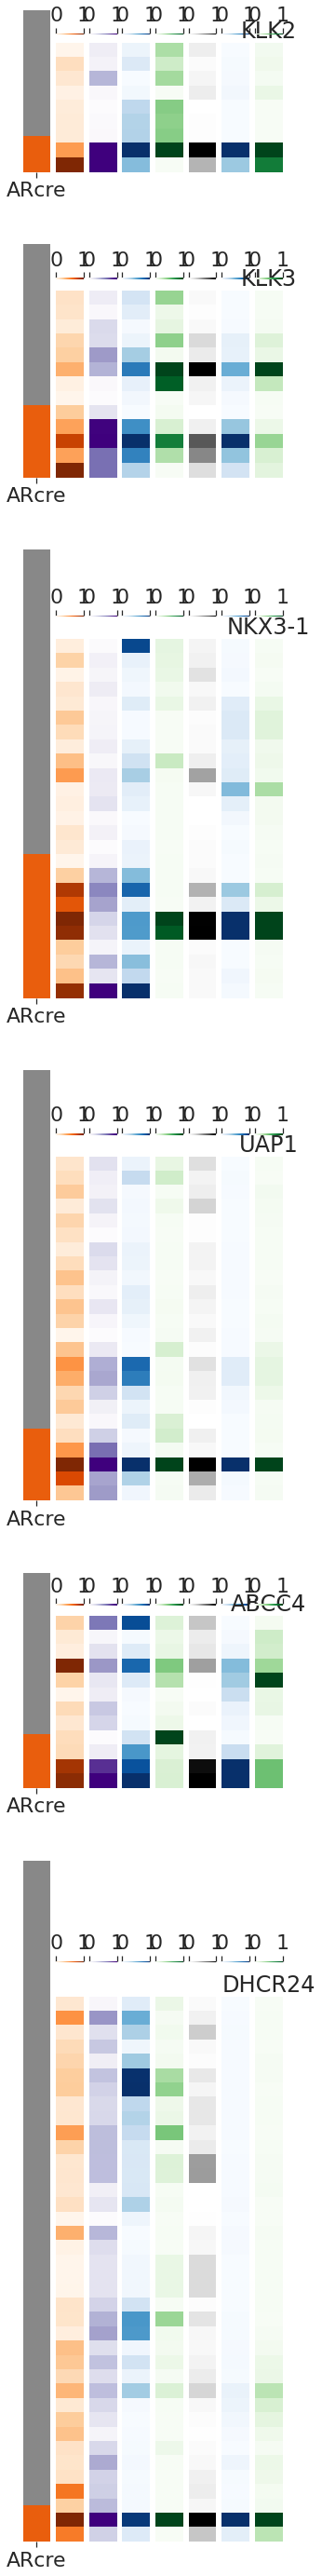

In [55]:

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('Custom', ('#888888', '#e95e0d'), 2)


fig = plt.figure(figsize=[5,50])
gs = gridspec.GridSpec(nrows=6, ncols=8, height_ratios=[9, 13, 25, 24, 12, 38])

palette = [ 'Oranges', 'Purples', 'Blues','Greens','Greys', 'Blues', 'Greens']
for i, gene in enumerate(genes):

	tmp = B[B['Gene'] == gene]

	tmp['ARcre'] = (tmp['Class'] == 'ARcre').astype(int)

	tmp = tmp.sort_values(['ARcre','Enhancer'])
		
	
	fig.add_subplot(gs[i, 0])
	sns.heatmap(pd.DataFrame(tmp['ARcre']), cmap=cmap, cbar=False)#cbar_kws = dict(use_gridspec=False,location="top"))
	
	plt.yticks([])

	

	for j, s in enumerate([ 'AR', 'FOXA1', 'H3K27ac', 'H3K4me3', 'ATAC', 'SD_AC','SD_ME']):
		
		fig.add_subplot(gs[i, j+1])

		tmp_ = pd.DataFrame(tmp[s])
		tmp_ = (tmp_ - tmp_.min(0)) / (tmp_.max(0) - tmp_.min(0))

		sns.heatmap(tmp_, cmap=palette[j], cbar_kws = dict(use_gridspec=False,location="top"))
		plt.yticks([])
		plt.xticks([])	
	
	plt.title(gene)



fig.savefig(f"../plots/SD_figure.pdf", bbox_inches="tight", pad_inches=1)


In [53]:
gene = 'KLK2'

tmp = B[B['Gene'] == gene]

tmp['ARcre'] = (tmp['Class'] == 'ARcre').astype(int)

tmp = tmp.sort_values(['ARcre','Enhancer'])

tmp

/tmp/ipykernel_221407/4182857299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['ARcre'] = (tmp['Class'] == 'ARcre').astype(int)


,Gene,Promoter,AC_DOM,ME_DOM,Class,Enhancer,SD_AC,SD_ME,FC_AC,FC_ME,ATAC,AR,FOXA1,H3K27ac,H3K4me3,ARcre
89,KLK2,chr19:51374195-51379195,False,False,High,chr19:51012110-51017110,0.105256,0.240292,0.000000,0.659838,3.111598,0.880856,1.194877,3.458430,1.941121,0
90,KLK2,chr19:51374195-51379195,False,False,cre,chr19:51159390-51164390,0.310253,0.340926,0.515253,-0.645294,1.667632,2.580222,1.044073,6.328011,1.358182,0
87,KLK2,chr19:51374195-51379195,False,False,High,chr19:51224086-51229086,0.461566,0.182452,1.185130,0.181067,2.443485,2.023247,2.106935,1.577248,2.085882,0
92,KLK2,chr19:51374195-51379195,False,False,cre,chr19:51422959-51427959,0.798245,0.518797,0.273213,0.907092,3.175640,1.232627,0.879008,2.410275,0.228771,0
93,KLK2,chr19:51374195-51379195,False,False,High,chr19:51867172-51872172,0.145834,0.091210,-0.371668,-0.173739,1.244157,1.632411,0.774004,10.921430,2.523792,0
94,KLK2,chr19:51374195-51379195,False,False,Mid-high,chr19:51868731-51873731,0.145834,0.091210,-0.371668,-0.173739,1.528090,1.721048,0.851466,12.237721,2.416490,0
95,KLK2,chr19:51374195-51379195,False,False,Mid-low,chr19:51868853-51873853,0.145834,0.091210,-0.371668,-0.173739,1.519449,1.733241,0.858886,12.390376,2.508124,0
88,KLK2,chr19:51374195-51379195,True,True,ARcre,chr19:51370076-51375076,24.151141,4.716058,0.932025,1.147238,14.651816,5.365776,4.091508,35.833192,5.327948,1
91,KLK2,chr19:51374195-51379195,False,False,ARcre,chr19:51390631-51395631,9.309791,3.845925,0.567747,1.918029,6.666886,10.955909,4.081701,16.551578,0.223003,1


,Gene,Promoter,AC_DOM,ME_DOM,Class,Enhancer,SD_AC,SD_ME,FC_AC,FC_ME,ATAC,AR,FOXA1,H3K27ac,H3K4me3,ARcre
75,KLK3,chr19:51355671-51360671,False,False,Mid-high,chr19:50885096-50890096,0.248379,0.327532,0.000000,0.330343,2.492316,2.659634,1.508667,10.073034,6.509867,0
76,KLK3,chr19:51355671-51360671,False,False,cre,chr19:51159390-51164390,0.249548,0.243959,-0.200934,0.617208,1.667632,2.580222,1.044073,6.328011,1.358182,0
77,KLK3,chr19:51355671-51360671,False,False,High,chr19:51224086-51229086,0.436179,0.496565,0.044049,0.876141,2.443485,2.023247,2.106935,1.577248,2.085882,0
78,KLK3,chr19:51355671-51360671,False,False,High,chr19:51305686-51310686,2.688060,2.636405,-0.669866,0.806209,7.148530,3.324662,2.038801,3.851522,6.890039,0
79,KLK3,chr19:51355671-51360671,False,False,low,chr19:51337969-51342969,2.460711,1.653765,0.193711,0.881860,4.941471,3.675420,3.314644,19.040145,0.706446,0
81,KLK3,chr19:51355671-51360671,False,True,cre,chr19:51362463-51367463,14.181060,16.256747,-0.091545,2.123337,25.457139,4.819953,2.870310,37.517547,15.821647,0
84,KLK3,chr19:51355671-51360671,False,False,High,chr19:51411494-51416494,1.941415,4.345756,-0.278233,1.604783,3.967781,1.589941,1.005309,5.246468,14.497666,0
85,KLK3,chr19:51355671-51360671,False,False,cre,chr19:51422959-51427959,0.613801,0.268611,0.433780,-0.020118,3.175640,1.232627,0.879008,2.410275,0.228771,0
86,KLK3,chr19:51355671-51360671,False,False,Mid-high,chr19:51609127-51614127,0.298042,0.150134,-0.666935,0.181067,1.205886,3.811735,1.783863,0.945978,0.590329,0
80,KLK3,chr19:51355671-51360671,False,False,ARcre,chr19:51342895-51347895,11.074495,1.404580,0.095280,0.591641,4.325991,5.334109,5.665975,33.342566,3.044179,1


In [35]:
tmp

,Gene,Promoter,AC_DOM,ME_DOM,Class,Enhancer,SD_AC,SD_ME,FC_AC,FC_ME,ATAC,AR,FOXA1,H3K27ac,H3K4me3,ARcre
0,UAP1,chr1:162528823-162533823,False,False,Mid-high,chr1:161733584-161738584,0.393467,0.087908,0.510570,0.014544,1.066034,1.408937,1.201367,9.987067,2.560006,0
81,KLK3,chr19:51355671-51360671,False,True,cre,chr19:51362463-51367463,14.181060,16.256747,-0.091545,2.123337,25.457139,4.819953,2.870310,37.517547,15.821647,0
79,KLK3,chr19:51355671-51360671,False,False,low,chr19:51337969-51342969,2.460711,1.653765,0.193711,0.881860,4.941471,3.675420,3.314644,19.040145,0.706446,0
78,KLK3,chr19:51355671-51360671,False,False,High,chr19:51305686-51310686,2.688060,2.636405,-0.669866,0.806209,7.148530,3.324662,2.038801,3.851522,6.890039,0
77,KLK3,chr19:51355671-51360671,False,False,High,chr19:51224086-51229086,0.436179,0.496565,0.044049,0.876141,2.443485,2.023247,2.106935,1.577248,2.085882,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,KLK3,chr19:51355671-51360671,True,False,ARcre,chr19:51352016-51357016,27.839222,6.574684,1.619321,1.228227,18.807628,8.924705,5.719065,51.972176,12.727909,1
83,KLK3,chr19:51355671-51360671,False,False,ARcre,chr19:51390631-51395631,5.363647,2.319742,0.210604,2.068335,6.666886,10.955909,4.081701,16.551578,0.223003,1
82,KLK3,chr19:51355671-51360671,False,False,ARcre,chr19:51370076-51375076,11.409915,3.055236,0.355946,1.522772,14.651816,5.365776,4.091508,35.833192,5.327948,1
103,NKX3-1,chr8:23537940-23542940,False,False,ARcre,chr8:23498924-23503924,0.966581,1.182295,0.943813,0.831651,1.579367,4.503925,4.855069,2.741859,0.088749,1


In [32]:
tmp.min(0)

ATAC       0.408598
AR         0.911188
FOXA1      0.204437
H3K27ac    0.334990
H3K4me3    0.129665
SD_AC      0.102854
SD_ME      0.183186
dtype: float64

In [44]:
B.loc[(B['Gene']==gene),:]

,Gene,Promoter,AC_DOM,ME_DOM,Class,Enhancer,SD_AC,SD_ME,FC_AC,FC_ME,ATAC,AR,FOXA1,H3K27ac,H3K4me3,STARR
96,NKX3-1,chr8:23537940-23542940,False,False,Mid-high,chr8:23312708-23317708,0.790109,1.512820,1.015212,-0.494292,1.627669,1.361328,0.936782,3.145451,1.957500,0.629937
97,NKX3-1,chr8:23537940-23542940,False,False,cre,chr8:23327535-23332535,0.959113,2.119519,0.521687,0.392294,0.722126,2.306978,1.054287,0.350174,0.163075,0.181582
98,NKX3-1,chr8:23537940-23542940,False,False,cre,chr8:23329539-23334539,0.959113,2.119519,0.521687,0.392294,0.912156,1.825887,1.140542,0.366298,0.123632,0.111040
99,NKX3-1,chr8:23537940-23542940,False,False,cre,chr8:23363990-23368990,0.635708,0.807459,1.043717,0.910177,0.908799,1.217261,1.684670,2.313752,0.139089,0.303268
100,NKX3-1,chr8:23537940-23542940,False,False,High,chr8:23383969-23388969,0.705873,1.023484,0.128065,-0.154599,1.759132,2.492823,0.905382,5.097775,4.749324,1.917164
101,NKX3-1,chr8:23537940-23542940,False,False,cre,chr8:23446193-23451193,2.868105,4.787965,1.412890,1.024082,1.172492,1.034327,1.880291,2.878144,0.262696,1.227379
102,NKX3-1,chr8:23537940-23542940,False,False,ARcre,chr8:23475838-23480838,2.468942,2.724629,0.277364,0.436772,4.435486,5.302563,5.903660,19.831884,0.283428,3.096869
103,NKX3-1,chr8:23537940-23542940,False,False,ARcre,chr8:23498924-23503924,0.966581,1.182295,0.943813,0.831651,1.579367,4.503925,4.855069,2.741859,0.088749,0.444493
104,NKX3-1,chr8:23537940-23542940,False,False,cre,chr8:23509024-23514024,0.661282,0.541569,-0.978852,0.086078,0.497781,1.121620,2.272585,2.146968,0.225978,0.995928
105,NKX3-1,chr8:23537940-23542940,False,False,ARcre,chr8:23535963-23540963,6.349020,13.729060,1.074150,0.829951,9.991052,6.083069,3.042172,14.724195,19.276707,7.662686


In [228]:
tmp.mean()

ATAC       4.440892e-18
AR        -4.440892e-18
FOXA1      4.440892e-17
H3K27ac   -1.110223e-16
H3K4me3    2.220446e-18
STARR     -8.881784e-18
FC_AC      0.000000e+00
FC_ME     -4.440892e-17
dtype: float64

ATAC       4.440892e-18
AR        -4.440892e-18
FOXA1      4.440892e-17
H3K27ac   -1.110223e-16
H3K4me3    2.220446e-18
STARR     -8.881784e-18
FC_AC      0.000000e+00
FC_ME     -4.440892e-17
dtype: float64

In [ ]:
tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())

In [221]:

tmp = B.loc[(B['Gene']==gene) & (B['Class'].isin(['ARcre', 'cre'])), [ 'ATAC', 'AR', 'FOXA1', 'H3K27ac', 'H3K4me3', 'STARR', 'SD_AC', 'SD_ME',]]
tmp

,ATAC,AR,FOXA1,H3K27ac,H3K4me3,STARR,SD_AC,SD_ME
97,0.061056,-0.584603,0.001020,0.205407,0.256872,0.075999,0.959113,2.119519
98,0.072201,-0.419015,-0.000182,0.196372,0.211313,0.035292,0.959113,2.119519
99,0.661905,-0.053160,-0.106631,0.244225,0.092846,-0.119662,0.635708,0.807459
101,0.608659,0.171189,0.234154,0.940171,-0.131180,0.647072,2.868105,4.787965
102,0.968227,0.789252,0.713421,0.719165,0.113092,0.891693,2.468942,2.724629
103,1.815486,1.035729,1.092250,0.652744,0.026222,0.198434,0.966581,1.182295
104,0.067507,-0.183266,0.293439,0.494354,-0.173744,-0.278269,0.661282,0.541569
105,0.540534,0.825907,0.463167,0.882558,0.589169,0.686905,6.349020,13.729060
106,0.554812,0.829037,0.390385,0.898557,0.471233,0.688250,6.349020,13.729060
107,0.157905,-0.351587,0.164227,0.234545,-0.010363,-0.041597,0.140798,0.218350


In [ ]:
tmp = B.loc[B['Gene']=='KLK3', ['SD_AC', 'SD_ME', 'ATAC', 'AR', 'FOXA1', 'H3K27ac', 'H3K4me3', 'STARR']]


tmp = (tmp - tmp.mean()) / tmp.std()


sns.heatmap(tmp , cmap='coolwarm')

/home/ualtintas/miniconda/envs/notebook/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='SD_AC', ylabel='Count'>

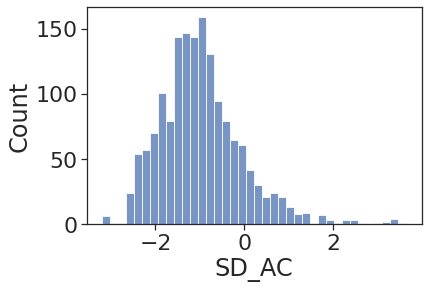

In [135]:
sns.histplot(np.log(B['SD_AC']))

[0.98167289 0.98211533 0.98463365 ... 0.99999791 0.99999829 0.99999866]


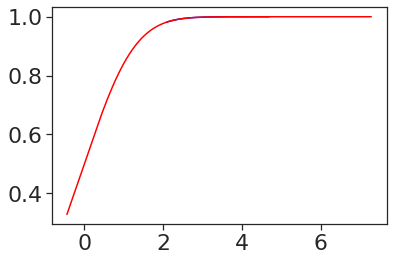

In [131]:
s = 'AR_VEH'
x = np.sort(np.log2(B[s]))
y = norm.cdf(x)



s = 'ATAC_TRE'
x_2 = np.sort(np.log2(B[s]))
y_2 = norm.cdf(x_2)

plt.plot(x, y, color='blue')
plt.plot(x_2, y_2, color='red')


In [122]:
s = 'AR_VEH'

B[s]

0       15.135317
1       20.618879
2        9.749264
3       18.083568
4       20.147558
          ...    
1625     6.783258
1626     6.553488
1627     8.085694
1628     8.471109
1629     6.062472
Name: AR_VEH, Length: 1630, dtype: float64

In [102]:
for gene in B['Gene'].unique():
	B[B['Gene'] == gene]
	break

In [136]:
B[B['Gene'] == 'UAP1']

,Gene,Promoter,AC_DOM,ME_DOM,Class,Enhancer,SD_AC,SD_ME,ATAC_VEH,ATAC_TRE,AR_VEH,AR_TRE,FOXA1_VEH,FOXA1_TRE,H3K27ac_VEH,H3K27ac_TRE,H3K4me3_VEH,H3K4me3_TRE,STARR_VEH,STARR_TRE
30,UAP1,chr1:162528823-162533823,False,False,Mid-high,chr1:161733584-161738584,0.393467,0.087908,10.615975,12.686913,12.416917,9.935878,15.644096,15.073920,16.618083,13.335844,45.019209,43.883169,8.655681,11.691834
31,UAP1,chr1:162528823-162533823,False,False,cre,chr1:162133028-162138028,0.356571,0.200031,15.658716,15.508879,13.687971,13.816310,17.640792,12.982094,15.291337,16.031376,1.756337,1.442562,9.022193,8.594219
32,UAP1,chr1:162528823-162533823,False,False,cre,chr1:162135646-162140646,0.356571,0.200031,13.380203,14.384631,13.314572,14.840340,16.951677,13.080352,15.066364,15.519649,1.716931,1.441223,8.615262,8.555581
33,UAP1,chr1:162528823-162533823,False,False,Mid-low,chr1:162332697-162337697,0.260478,0.329517,7.595543,4.785764,18.250619,18.048800,15.680538,16.562003,4.420054,4.290300,0.883158,0.733980,21.588437,21.983286
34,UAP1,chr1:162528823-162533823,False,False,High,chr1:162465133-162470133,0.370794,1.406758,13.786319,13.105085,15.029174,9.090313,13.264879,11.288820,13.987985,13.940735,61.752640,68.757306,16.760525,12.205845
35,UAP1,chr1:162528823-162533823,False,False,ARcre,chr1:162536309-162541309,30.874060,15.780470,44.833352,62.635687,10.025973,24.342638,20.798147,31.761004,142.438115,190.146510,36.318099,29.626530,9.452847,15.494030
36,UAP1,chr1:162528823-162533823,False,False,cre,chr1:162663921-162668921,0.841687,0.311891,10.359554,9.764964,10.143203,9.253363,13.394499,11.033333,35.099377,39.492360,1.070785,1.272678,8.395324,7.375537
37,UAP1,chr1:162528823-162533823,False,False,cre,chr1:161579789-161584789,0.136779,0.156167,23.475585,27.153559,13.944708,14.803888,13.155768,17.037079,9.883120,9.212936,26.812404,25.705576,8.419922,5.622831
38,UAP1,chr1:162528823-162533823,False,False,ARcre,chr1:161852672-161857672,0.190959,0.260593,7.649142,7.039133,8.392301,16.137853,17.344442,22.611288,9.580869,12.124108,1.980321,2.938986,7.557071,9.657186
39,UAP1,chr1:162528823-162533823,False,False,cre,chr1:162022863-162027863,0.272773,0.602756,6.138399,8.605917,14.644282,9.014938,13.252429,11.274870,3.650563,3.482655,1.292329,1.319539,5.174840,4.656063


In [96]:
B.groupby('Gene').max()

,Promoter,Class,Enhancer,SD_AC,SD_ME,ATAC_VEH,ATAC_TRE,AR_VEH,AR_TRE,FOXA1_VEH,FOXA1_TRE,H3K27ac_VEH,H3K27ac_TRE,H3K4me3_VEH,H3K4me3_TRE,STARR_VEH,STARR_TRE,Pairs
Gene,,,,,,,,,,,,,,,,,,
ABCC4,chr13:95951183-95956183,cre,chr13:96326948-96331948,3.003990,2.757554,47.234039,62.042173,14.304061,26.960341,20.364255,31.048224,95.337944,126.846133,78.146086,82.147007,16.199960,21.768257,chr13:95951183-95956183;chr13:96326948-96331948
ABHD2,chr15:89628881-89633881,low,chr15:91563333-91568333,38.635528,6.396712,99.311761,93.320669,18.666034,30.582154,24.864538,35.421664,81.596346,128.541563,109.869531,104.502925,125.959894,122.776383,chr15:89628881-89633881;chr15:91563333-91568333
ACSL3,chr2:223723160-223728160,cre,chr2:224699799-224704799,7.596154,1.984086,30.653139,48.582542,12.775670,26.469642,31.274862,43.212642,55.253136,65.982541,60.905170,63.423307,9.784727,10.807246,chr2:223723160-223728160;chr2:224699799-224704799
ACTN1,chr14:69443657-69448657,low,chr14:69921826-69926826,2.002095,1.349011,40.627988,43.237800,20.934336,18.080752,21.578897,25.838704,52.968560,50.384785,92.423971,95.053028,34.953375,27.345510,chr14:69443657-69448657;chr14:69921826-69926826
ADAMTS1,chr21:28215228-28220228,cre,chr21:30447296-30452296,1.013663,1.324001,46.140210,119.856299,17.225636,24.261905,28.014528,28.039587,114.347182,131.875336,71.671963,70.924392,36.856998,25.322102,chr21:28215228-28220228;chr21:30447296-30452296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VAPA,chr18:9911559-9916559,low,chr18:9885636-9890636,0.805580,0.838953,54.335896,49.664749,19.244552,26.501221,17.071382,19.630984,28.274214,26.021325,75.593713,77.326580,16.758844,19.008769,chr18:9911559-9916559;chr18:9885636-9890636
XRCC5,chr2:216971520-216976520,low,chr2:217529011-217534011,0.748369,1.361568,22.632567,25.428023,13.298257,16.767441,18.455247,21.497728,63.882769,73.899405,60.023318,57.064155,95.436981,74.670395,chr2:216971520-216976520;chr2:217529011-217534011
XRCC6,chr22:42014623-42019623,low,chr22:43199026-43204026,1.281404,2.550250,99.749486,109.846034,23.207929,36.518523,26.671345,31.625253,178.891233,142.178202,220.556464,229.971878,55.465843,63.321133,chr22:42014623-42019623;chr22:43199026-43204026


<AxesSubplot:xlabel='SD_AC', ylabel='AR_TRE'>

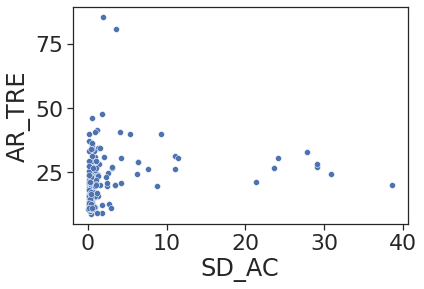

In [93]:
sns.scatterplot(data=B[B['Class'] == 'ARcre'], x='SD_AC', y='AR_TRE')

In [94]:
for gene in B['Gene'].unique():
	B['Gene'] == gene

,Gene,Promoter,Class,Enhancer,SD_AC,SD_ME,ATAC_VEH,ATAC_TRE,AR_VEH,AR_TRE,FOXA1_VEH,FOXA1_TRE,H3K27ac_VEH,H3K27ac_TRE,H3K4me3_VEH,H3K4me3_TRE,STARR_VEH,STARR_TRE,Pairs
0,GNAI3,chr1:110088733-110093733,High,chr1:109966562-109971562,0.516969,0.736325,46.920463,46.531725,15.135317,11.618526,13.226705,12.776449,25.137037,20.683171,79.680613,78.972017,21.166053,22.722301,chr1:110088733-110093733;chr1:109966562-109971562
1,GNAI3,chr1:110088733-110093733,Mid-low,chr1:110034221-110039221,0.678457,1.396202,31.276351,37.382751,20.618879,22.015194,15.195051,21.460569,11.267007,10.126584,38.800548,38.891510,25.901398,28.272986,chr1:110088733-110093733;chr1:110034221-110039221
2,GNAI3,chr1:110088733-110093733,cre,chr1:110103387-110108387,3.340422,2.491681,17.418015,13.852177,9.749264,10.021858,10.430995,8.127986,36.032172,34.997145,3.286185,4.719293,5.485783,5.313849,chr1:110088733-110093733;chr1:110103387-110108387
3,GNAI3,chr1:110088733-110093733,Mid-high,chr1:110159959-110164959,0.778742,2.894556,33.829002,30.967946,18.083568,18.532630,14.895631,13.019642,39.355459,33.574322,85.307898,83.474508,43.433827,37.152022,chr1:110088733-110093733;chr1:110159959-110164959
4,GNAI3,chr1:110088733-110093733,ARcre,chr1:110172872-110177872,0.877539,0.987934,8.718435,17.810599,20.147558,30.899457,14.778586,16.276940,5.796923,8.596760,1.502159,14.155290,53.947840,58.455291,chr1:110088733-110093733;chr1:110172872-110177872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,SAT1,chrX:23798790-23803790,cre,chrX:23917919-23922919,1.483423,2.179797,29.310047,29.181427,6.783258,6.825485,5.750923,8.532464,15.374251,12.640366,26.915260,22.101095,7.114959,5.819749,chrX:23798790-23803790;chrX:23917919-23922919
1626,SAT1,chrX:23798790-23803790,cre,chrX:23935573-23940573,0.367377,0.482881,2.264615,2.182832,6.553488,6.980256,7.264590,5.452752,1.612282,1.258087,0.515990,0.642987,5.323695,3.996593,chrX:23798790-23803790;chrX:23935573-23940573
1627,SAT1,chrX:23798790-23803790,Mid-low,chrX:24042803-24047803,0.576104,0.628951,14.503887,12.440123,8.085694,8.542607,9.382611,11.296466,16.995318,12.239257,41.545464,42.450422,8.713032,7.165493,chrX:23798790-23803790;chrX:24042803-24047803
1628,SAT1,chrX:23798790-23803790,High,chrX:24070333-24075333,0.978180,0.949004,16.407909,19.078671,8.471109,7.205712,8.853126,7.719570,23.747360,20.126930,37.124319,37.241308,16.042849,20.257355,chrX:23798790-23803790;chrX:24070333-24075333


In [ ]:
sns.scatterplot(data=B, x='SD_AC', y='STARR_TRE')

In [50]:
L = np.stack((
	(1+T[:,1]) / (1+T[:,0]), 
	(1+T[:,3]) / (1+T[:,2]),
	(1+T[:,5]) / (1+T[:,4]),
	(1+T[:,7]) / (1+T[:,6]),
	(1+T[:,9]) / (1+T[:,8]),
	(1+T[:,11]) / (1+T[:,10])
), 1)

L = pd.DataFrame(L, index=bed['Name'], columns=['ATAC', 'AR', 'FOXA1', 'H3K27ac', 'H3K4me3', 'STARR'])

L

,ATAC,AR,FOXA1,H3K27ac,H3K4me3,STARR
Name,,,,,,
chr1:751985-756985,1.397328,1.736503,1.141219,1.345833,0.883160,1.145986
chr1:760223-765223,1.061251,1.041728,1.149897,1.091380,1.005326,1.037998
chr1:791444-796444,0.985760,1.175001,1.047650,1.109384,1.006141,0.930930
chr1:802847-807847,0.817002,0.929395,1.109570,1.001716,1.082616,1.095910
chr1:863945-868945,0.934557,1.221552,1.094402,0.877773,1.648739,0.940745
...,...,...,...,...,...,...
chrY:28496921-28501921,0.836702,0.873690,1.289747,1.020698,1.033127,1.010607
chrY:28508739-28513739,1.910121,0.970754,1.104578,0.979338,1.074537,1.000000
chrY:28534627-28539627,0.976060,0.762132,0.690769,1.473115,0.937079,1.000000


In [69]:
B = pd.DataFrame(B, columns=['Gene', 'Promoter','Class', 'Enhancer', 'SD_AC', 'SD_ME'])

for s in ['ATAC', 'AR', 'FOXA1', 'H3K27ac', 'H3K4me3', 'STARR']:
	MAPtmp = dict(zip(L.index, L[s]))
	B[s] = B['Enhancer'].map(MAPtmp)

B['Pairs'] = B['Promoter'] + ';' + B['Enhancer']
B

,Gene,Promoter,Class,Enhancer,SD_AC,SD_ME,ATAC,AR,FOXA1,H3K27ac,H3K4me3,STARR,Pairs
0,GNAI3,chr1:110088733-110093733,High,chr1:109966562-109971562,0.516969,0.736325,0.991888,0.782044,0.968351,0.829596,0.991217,1.070209,chr1:110088733-110093733;chr1:109966562-109971562
1,GNAI3,chr1:110088733-110093733,Mid-low,chr1:110034221-110039221,0.678457,1.396202,1.189191,1.064588,1.386879,0.907033,1.002285,1.088159,chr1:110088733-110093733;chr1:110034221-110039221
2,GNAI3,chr1:110088733-110093733,cre,chr1:110103387-110108387,3.340422,2.491681,0.806394,1.025359,0.798529,0.972051,1.334355,0.973491,chr1:110088733-110093733;chr1:110103387-110108387
3,GNAI3,chr1:110088733-110093733,Mid-high,chr1:110159959-110164959,0.778742,2.894556,0.917854,1.023531,0.881981,0.856745,0.978758,0.858626,chr1:110088733-110093733;chr1:110159959-110164959
4,GNAI3,chr1:110088733-110093733,ARcre,chr1:110172872-110177872,0.877539,0.987934,1.935558,1.508423,1.094961,1.411927,6.056884,1.082031,chr1:110088733-110093733;chr1:110172872-110177872
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,SAT1,chrX:23798790-23803790,cre,chrX:23917919-23922919,1.483423,2.179797,0.995757,1.005425,1.412024,0.833038,0.827544,0.840392,chrX:23798790-23803790;chrX:23917919-23922919
1626,SAT1,chrX:23798790-23803790,cre,chrX:23935573-23940573,0.367377,0.482881,0.974948,1.056499,0.780771,0.864411,1.083772,0.790138,chrX:23798790-23803790;chrX:23935573-23940573
1627,SAT1,chrX:23798790-23803790,Mid-low,chrX:24042803-24047803,0.576104,0.628951,0.866887,1.050289,1.184333,0.735706,1.021270,0.840674,chrX:23798790-23803790;chrX:24042803-24047803
1628,SAT1,chrX:23798790-23803790,High,chrX:24070333-24075333,0.978180,0.949004,1.153422,0.866394,0.884955,0.853704,1.003069,1.247289,chrX:23798790-23803790;chrX:24070333-24075333


In [79]:
for s in ['SD_AC', 'SD_ME', 'ATAC', 'AR', 'FOXA1', 'H3K27ac', 'H3K4me3', 'STARR']:
	B[f'log_{s}'] = np.log2(B[s])

/home/ualtintas/miniconda/envs/notebook/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='log_SD_AC', ylabel='log_AR'>

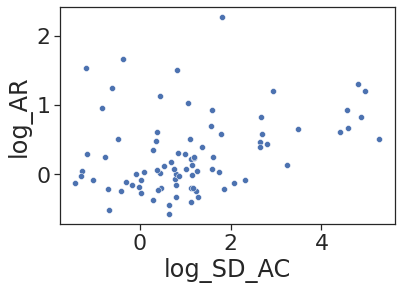

In [81]:
tmp = B[B['Pairs'].isin(D['Pairs_AC'])]


sns.scatterplot(data=tmp, x='log_SD_AC', y='log_AR')

In [86]:
spearmanr(B['log_SD_AC'], B['log_AR']), spearmanr(B['log_SD_AC'], B['log_STARR'])

(SignificanceResult(statistic=0.15870972437992995, pvalue=1.1667693812352708e-10),
 SignificanceResult(statistic=0.024842390461921156, pvalue=0.31617288355966694))

<AxesSubplot:xlabel='log_SD_AC', ylabel='log_STARR'>

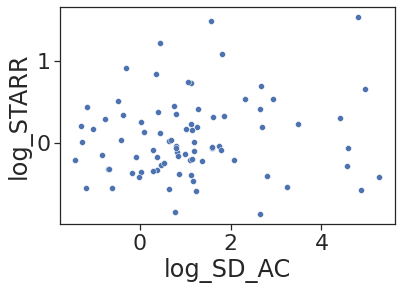

In [82]:
sns.scatterplot(data=tmp, x='log_SD_AC', y='log_STARR')

<AxesSubplot:xlabel='SD_AC', ylabel='FOXA1'>

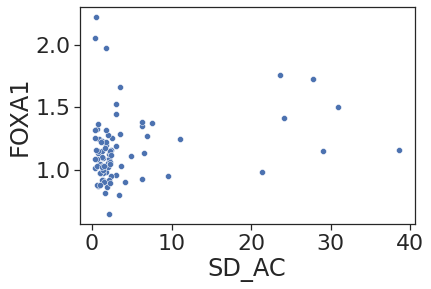

In [74]:
sns.scatterplot(data=tmp, x='SD_AC', y='FOXA1')

<AxesSubplot:xlabel='SD_AC', ylabel='H3K27ac'>

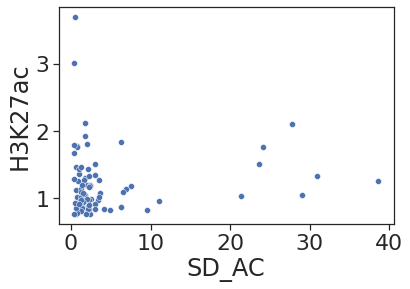

In [75]:
sns.scatterplot(data=tmp, x='SD_AC', y='H3K27ac')

<AxesSubplot:xlabel='SD_AC', ylabel='H3K4me3'>

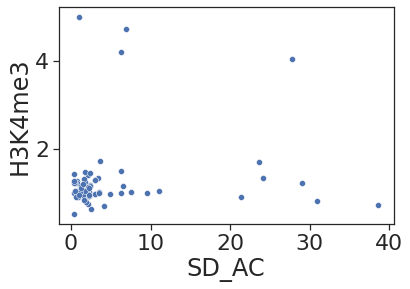

In [76]:
sns.scatterplot(data=tmp, x='SD_AC', y='H3K4me3')

In [52]:
B[B['Gene'].isin(['KLK3'])]

,Gene,Promoter,Class,Enhancer,SD_AC,SD_ME,ATAC,AR,FOXA1,H3K27ac,H3K4me3,STARR
759,KLK3,chr19:51355671-51360671,ARcre,chr19:51352016-51357016,27.839222,6.574684,3.178832,2.482922,1.726139,2.101548,4.044908,2.902890
760,KLK3,chr19:51355671-51360671,Mid-high,chr19:50885096-50890096,0.248379,0.327532,0.970448,1.021969,1.113307,0.859008,0.912645,1.076635
761,KLK3,chr19:51355671-51360671,cre,chr19:51159390-51164390,0.249548,0.243959,1.121734,1.070580,1.084794,0.796218,0.910153,0.899484
762,KLK3,chr19:51355671-51360671,High,chr19:51224086-51229086,0.436179,0.496565,0.975514,0.897608,1.188681,0.821615,1.030887,1.200856
763,KLK3,chr19:51355671-51360671,High,chr19:51305686-51310686,2.688060,2.636405,1.733640,1.318056,1.027624,1.249668,1.175255,1.104926
764,KLK3,chr19:51355671-51360671,low,chr19:51337969-51342969,2.460711,1.653765,1.583814,1.680154,1.405689,1.408951,1.065514,0.864786
765,KLK3,chr19:51355671-51360671,ARcre,chr19:51342895-51347895,11.074495,1.404580,1.563567,1.752446,1.677106,1.553133,0.845314,1.418611
766,KLK3,chr19:51355671-51360671,cre,chr19:51362463-51367463,14.181060,16.256747,3.607680,1.723588,1.203575,2.256538,4.496614,1.586296
767,KLK3,chr19:51355671-51360671,ARcre,chr19:51370076-51375076,11.409915,3.055236,3.492467,1.595439,1.410235,1.762754,1.341626,0.959111
768,KLK3,chr19:51355671-51360671,ARcre,chr19:51390631-51395631,5.363647,2.319742,2.445630,2.835019,1.607055,1.983110,1.065491,1.555468


<AxesSubplot:xlabel='SD_AC', ylabel='AR'>

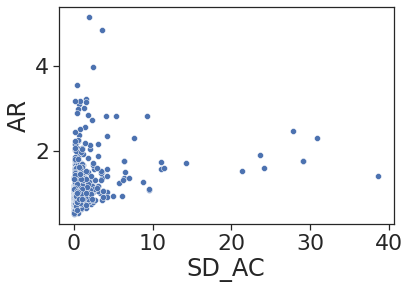

In [53]:
sns.scatterplot(data=D, x='SD_AC', y='AR')

<AxesSubplot:xlabel='SD_AC', ylabel='STARR'>

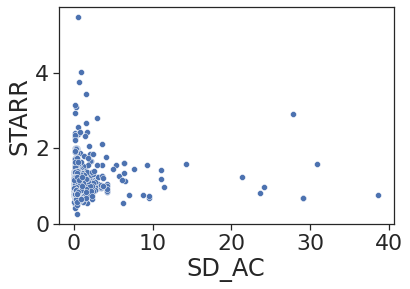

In [54]:
sns.scatterplot(data=B, x='SD_AC', y='STARR')

In [44]:
B[B['Gene'].isin(['KLK2'])]

,Gene,Promoter,Enhancer,SD_AC,SD_ME,ATAC,AR,FOXA1,H3K27ac,H3K4me3,STARR
772,KLK2,chr19:51374195-51379195,chr19:51224086-51229086,0.461566,0.182452,-0.035765,-0.155843,0.249362,-0.283466,0.043886,0.264063
773,KLK2,chr19:51374195-51379195,chr19:51370076-51375076,24.151141,4.716058,1.804246,0.673954,0.495935,0.817831,0.423983,-0.060231
774,KLK2,chr19:51374195-51379195,chr19:51012110-51017110,0.105256,0.240292,-0.228578,0.130971,-0.191055,-0.102478,0.043466,0.033037
775,KLK2,chr19:51374195-51379195,chr19:51159390-51164390,0.310253,0.340926,0.165731,0.098392,0.117422,-0.328765,-0.135820,-0.152831
776,KLK2,chr19:51374195-51379195,chr19:51390631-51395631,9.309791,3.845925,1.290206,1.503359,0.684420,0.987764,0.091518,0.637348
777,KLK2,chr19:51374195-51379195,chr19:51422959-51427959,0.798245,0.518797,0.765830,0.066587,-0.031173,0.609458,0.297971,-0.166015
778,KLK2,chr19:51374195-51379195,chr19:51867172-51872172,0.145834,0.091210,0.003698,0.074154,0.020631,-0.344693,-0.094201,-0.065126
779,KLK2,chr19:51374195-51379195,chr19:51868731-51873731,0.145834,0.091210,-0.026517,0.117445,-0.012333,-0.138523,-0.082433,-0.049223
780,KLK2,chr19:51374195-51379195,chr19:51868853-51873853,0.145834,0.091210,-0.029652,0.120887,-0.014946,-0.112055,-0.103034,-0.048136
